# Fermi limits with Sommerfeld enhancement

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
import scipy.integrate as integrate
from matplotlib import rc
import scipy.interpolate as interpolate

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 14})
rc('text', usetex=True)

figsize=(8,6)

At freeze-out, we want
$$
\langle \sigma v \rangle _{relic} = \frac{\pi \alpha^2}{M_{DM}^2} S_{FO} = \frac{\pi \alpha^2}{M_{DM}^2} 2\pi \frac{\alpha}{v} \frac{1}{1- e^{-2\pi \alpha / v}}
$$
where $\langle 1/ v \rangle\simeq 4$ at freeze-out. At these velocities, there's basically no difference between the thermally averaged Sommerfeld enhancement factor and the Sommerfeld enhancement factor calculated at $v = \langle v \rangle$. We also know that $\langle \sigma v \rangle _{relic} = 4.4\times 10^{-26} \mathrm{cm}^3 \mathrm{s}^{-1}$ for our model with non-self-conjugate DM. In reference [13], which is the paper about Fermi limits, they use self-conjugate DM, therefore we will have to weaken the limits by a factor of 2. We want to use the equation above to derive $\alpha(M)$ that reproduces the correct relic abundance, but the equation does not have an analytic solution. Below I solve it numerically.

In [2]:
sigmav_conversion = 1.52 * 10 ** 24 / (5.06 * 10 ** 13) ** 3 # Converts from GeV^-2 to cm^3s^-1
sigmav_relic = 4.4 * 10**(-26) # cm^-3s^-1
sigmav_relic_GeV = sigmav_relic / sigmav_conversion # GeV^-2

avg_vrel_FO = 1 / 4 # in units of c

def S(alpha, vrel):
	coefficient = 2 * np.pi * alpha / vrel
	return coefficient / (1 - np.exp(-coefficient))

# alpha with Sommerfeld enhancement
def alpha_single(M):
	equation_to_solve = lambda alpha : sigmav_relic_GeV - np.pi * alpha ** 2 / M ** 2 * S(alpha, avg_vrel_FO)
	return opt.fsolve(equation_to_solve, 0.1)[0]

alpha = np.vectorize(alpha_single)

# alpha without Sommerfeld enhancement
def simple_alpha(M):
	return M * np.sqrt(sigmav_relic_GeV / np.pi)

Below I'm plotting the dependence of $\alpha$ on $M_{DM}$ with this new equation, and I'm comparing it to the one I found in excercise 3.3 which was just a linear dependence.

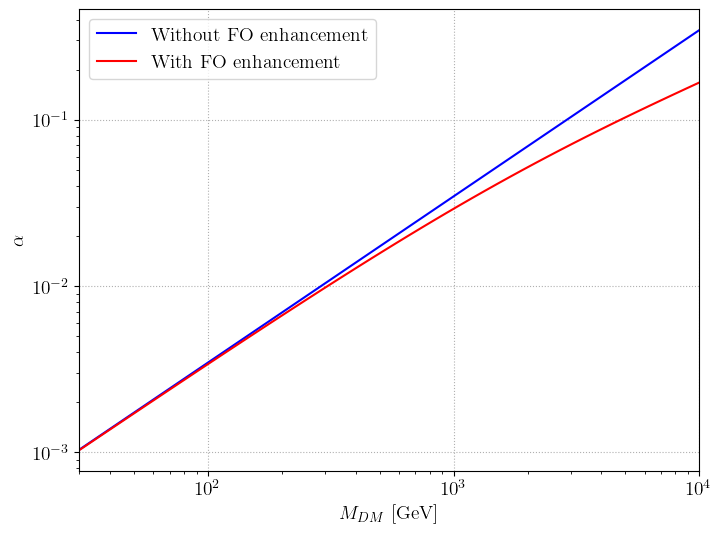

In [3]:
M_axis_alpha = np.logspace(np.log10(30), 4)

plt.figure(figsize=figsize)
plt.xlabel("$M_{DM}$ [GeV]")
plt.ylabel("$\\alpha$")
plt.xscale("log")
plt.yscale("log")
plt.grid(linestyle=':')
plt.margins(x=0)
plt.plot(M_axis_alpha, M_axis_alpha * np.sqrt(sigmav_relic_GeV / np.pi), color="blue", label="Without FO enhancement");
plt.plot(M_axis_alpha, alpha(M_axis_alpha), color="red", label="With FO enhancement");
plt.legend();
plt.savefig("alpha.pdf", bbox_inches='tight')

## Visualizing the Sommerfeld enhancement factor

In [27]:
x_axis = np.logspace(-5, 0, 200)
y_axis = np.logspace(1, 4, 200)
X, Y = np.meshgrid(x_axis, y_axis)

Z = S(alpha(Y), X)

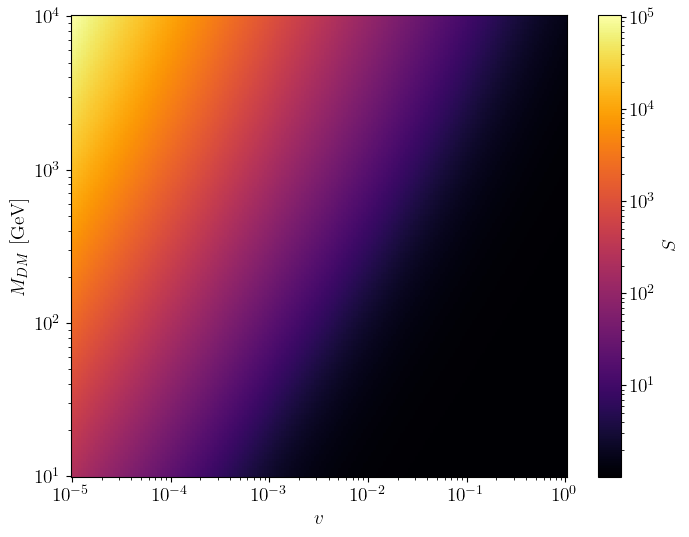

In [28]:
import matplotlib.colors as colors

fig, ax = plt.subplots(figsize=figsize)

im = ax.pcolormesh(
    X,
    Y,
    Z,
    norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()),
    cmap='inferno',
    shading='auto',
	rasterized=True
)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('$v$')
ax.set_ylabel('$M_{DM}$ [GeV]')

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('$S$')

plt.savefig("enhancement_factor_color.pdf", bbox_inches='tight')

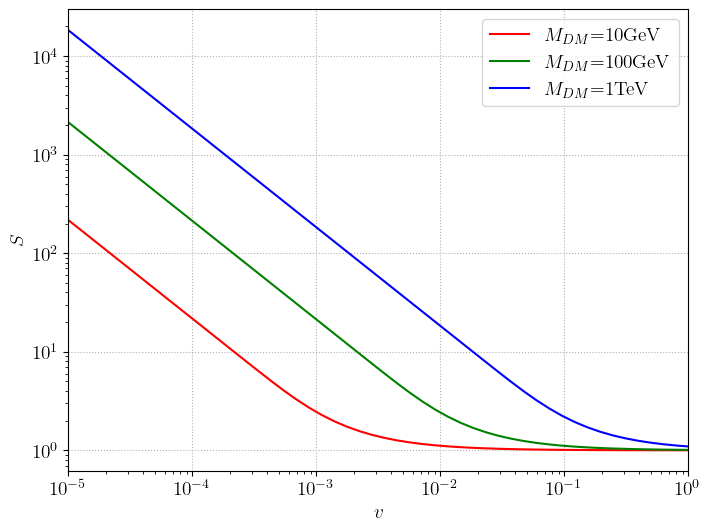

In [29]:
v_axis = np.logspace(-5, 0)

plt.figure(figsize=figsize)
plt.xlabel("$v$")
plt.ylabel("$S$")
plt.xscale("log")
plt.yscale("log")
plt.grid(linestyle=':')
plt.margins(x=0)
plt.plot(v_axis, S(alpha(10), v_axis), color="red", label="$M_{DM}$=10GeV");
plt.plot(v_axis, S(alpha(100), v_axis), color="green", label="$M_{DM}$=100GeV");
plt.plot(v_axis, S(alpha(1000), v_axis), color="blue", label="$M_{DM}$=1TeV");
plt.legend();
plt.savefig("enhancement_factor.pdf", bbox_inches='tight')

## Constraining the dark matter mass

I now use the result from the previous equation to calculate the enhanced cross section relevant for the Fermi limits today. The enhanced cross section is
$$
\langle \sigma v \rangle _{dSph} = \frac{\pi \alpha^2}{M_{DM}^2} \langle S_{dSph} \rangle = \frac{\pi \alpha^2}{M_{DM}^2} \left\langle 2\pi \frac{\alpha}{v} \frac{1}{1- e^{-2\pi \alpha / v}} \right\rangle
$$
From the literature, I gathered that $\beta \simeq 10 \mathrm{km}/\mathrm{s}$ is the line-of-sight velocity dispersion in dwarf spheroidal galaxies, which are the object of study of the Fermi collaboration. This means that the three-dimensional velocity dispersion is $\sqrt{3} \beta$.

In [30]:
vdisp_dSph = np.sqrt(3) * 10 / 300000 # sqrt(3)*10 km/s in units of c
avg_vrel_dSph = 4 * vdisp_dSph / np.sqrt(np.pi) # in units of c

def MB_dSph(vrel):
	return 1 / np.sqrt(4 * np.pi) * vrel**2 / vdisp_dSph**3 * np.exp(-vrel**2 / (4 * vdisp_dSph**2))

def avgS_single(alpha):
	integrand = lambda vrel : MB_dSph(vrel) * S(alpha, vrel)
	# Limit the integration to 4 times the average in order to prevent the integral from returning 0
	integral, _ = integrate.quad(integrand, 0, avg_vrel_dSph * 4)
	return integral

avgS = np.vectorize(avgS_single)

In [31]:
def sigmav_now(M):
	a = alpha(M)
	return sigmav_conversion * np.pi * a ** 2 / M ** 2 * avgS(a)

In [32]:
import csv

M = []
sigmav = []
with open('fermi-data.csv', 'r') as f:
	reader = csv.reader(f)
	next(reader)  # skip header

	for row in reader:
		if row:  # skip empty rows
			M.append(float(row[0]))
			sigmav.append(float(row[1]) * 10**(-26))

	M = np.array(M)
	sigmav = np.array(sigmav)

interpolated_Fermi_data = interpolate.CubicSpline(M, sigmav)

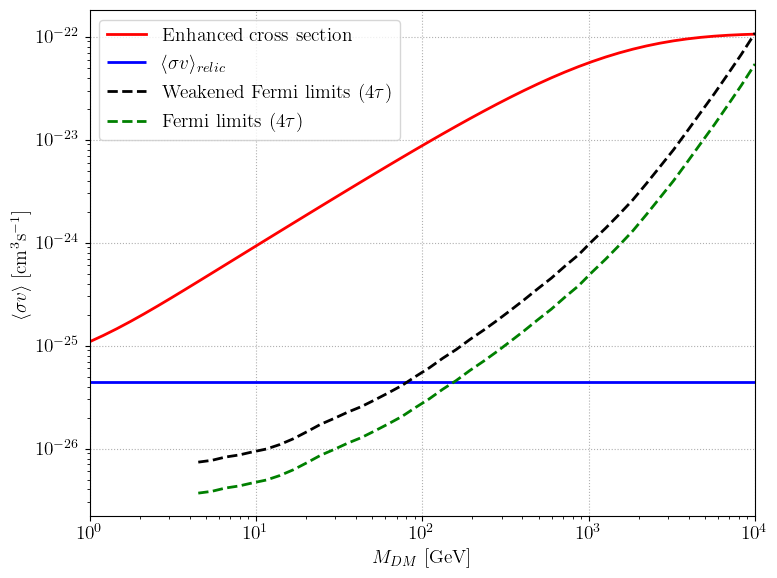

In [33]:
plt.figure(figsize=figsize)
plt.xlabel("$M_{DM}$ [GeV]")
plt.ylabel("$\\langle \\sigma v \\rangle \\ [\\mathrm{cm}^3\\mathrm{s}^{-1}]$")
plt.xscale("log")
plt.yscale("log")
plt.margins(x=0)
plt.grid(linestyle=':')
plt.plot(M_axis, sigmav_now(M_axis), color="red", label="Enhanced cross section", linewidth=2);
plt.hlines(y=sigmav_relic, xmin=M_axis[0], xmax=M_axis[-1], color="blue", label="$\\langle \\sigma v \\rangle_{relic}$", linewidth=2);
reduced_M_axis = M_axis[M_axis >= np.min(M)]
plt.plot(reduced_M_axis, interpolated_Fermi_data(reduced_M_axis) *  2, '--', color="black", label="Weakened Fermi limits ($4\\tau$)", linewidth=2);
plt.plot(reduced_M_axis, interpolated_Fermi_data(reduced_M_axis), '--', color="green", label="Fermi limits ($4\\tau$)", linewidth=2);
plt.legend();
plt.tight_layout()
plt.savefig("comparison.pdf", bbox_inches='tight')

In [34]:
sol = opt.fsolve(lambda x: interpolated_Fermi_data(x) * 2 - sigmav_relic, 82)[0]

print(f"Without Sommerfeld enhancement, prediction and limits meet at M={sol:.2f}GeV")

Without Sommerfeld enhancement, prediction and limits meet at M=80.67GeV


In [35]:
sol_enhanced = opt.fsolve(lambda x: interpolated_Fermi_data(x) * 2 - sigmav_now(x), 10**4)[0]
print(f"With Sommerfeld enhancement, prediction and limits meet at M={sol_enhanced / 1000:.2f}TeV.")

With Sommerfeld enhancement, prediction and limits meet at M=9.91TeV.


## Checking whether the Coulomb approximation was valid

I am now checking whether
$$
\frac{M_{DM} v_{rel}}{2m_V} \geq 1
$$

In [36]:
m_tau = 1.77682 # in GeV

ratio = sol_enhanced * avg_vrel_dSph / 4 / m_tau

print(f"The ratio is {ratio:.2f}.")

if ratio < 1:
	print("The Coulomb approximation was not valid, we should have used Yukawa or Hulthen.")
else:
	print("The Coulomb approximation was valid, we can use it to calculate the cross section.")

The ratio is 0.18.
The Coulomb approximation was not valid, we should have used Yukawa or Hulthen.


See page 5 of [0810.0713v3](https://arxiv.org/abs/0810.0713v3) for what it means to have a Yukawa potential. Basically, the Sommerfeld enhancement saturates at low velocities and this limits how big the enhancement can get.